In [1]:
import os
import sys
import time
import pickle
import string
from datetime import datetime
from datetime import timedelta
from itertools import chain, cycle
import collections
from pprint import pprint
from io import StringIO
import pathlib
import sqlite3

import numpy as np
import pandas as pd
import dask.dataframe as dd
from pandas.tools.plotting import parallel_coordinates
import matplotlib.pyplot as plt

#import urllib
#import webbrowser
#import codecs
from bs4 import BeautifulSoup
from xml.dom import minidom
from xml.etree import ElementTree as ET
#from lxml import etree as ET #Supports xpath syntax
import xmltodict 

import nltk
import re
import Levenshtein
import networkx as nx
import json

#from nominatim import Nominatim
#from mpl_toolkits.basemap import Basemap   #http://matplotlib.org/basemap/api/basemap_api.html
from matplotlib import cm
import geopy.geocoders as gg
from geopy.geocoders import Nominatim
import geopandas as gpd

#https://github.com/jupyter-widgets/ipyleaflet
#https://ipyleaflet.readthedocs.io/en/latest/
import ipyleaflet 
#from ipyleaflet import Map, basemaps, basemap_to_tiles, DrawControl, WMSLayer, Marker, MarkerCluster

import folium
import folium.plugins
#from folium.plugins import MarkerCluster
#from folium.plugins import FastMarkerCluster


#import plotly as py
#import plotly.graph_objs as go
#import plotly.figure_factory as ff

from IPython.display import Image, HTML, IFrame, FileLink, FileLinks #needed to render in notebook
from IPython.core.display import display

In [2]:
df_lemmas = pd.read_pickle('./df_lemmas.pkl')

In [9]:
df_lemmas.info(verbose=True, null_counts=True, memory_usage='deep') #, max_cols=100)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2416499 entries, 0 to 2416498
Data columns (total 52 columns):
Bundesland               1316889 non-null object
Bundesland_idno          1316889 non-null object
Gemeinde                 1198447 non-null object
Großregion               1296722 non-null object
Großregion_idno          1225463 non-null object
Kleinregion              1286463 non-null object
Kleinregion_idno         1209145 non-null object
Ort                      1198447 non-null object
Ort_idno                 1198447 non-null object
archiv                   2416419 non-null object
bibl                     1719656 non-null object
certainty                25631 non-null object
cit_def                  461023 non-null object
cit_interp               353677 non-null object
cit_note                 111690 non-null object
cit_pRef                 79913 non-null object
cit_quote                704560 non-null object
cit_re                   113327 non-null object
cit_ref       

In [10]:
df_lemmas.columns

Index(['Bundesland', 'Bundesland_idno', 'Gemeinde', 'Großregion',
       'Großregion_idno', 'Kleinregion', 'Kleinregion_idno', 'Ort', 'Ort_idno',
       'archiv', 'bibl', 'certainty', 'cit_def', 'cit_interp', 'cit_note',
       'cit_pRef', 'cit_quote', 'cit_re', 'cit_ref', 'cit_type', 'date',
       'entry_id', 'etym', 'filename', 'fragebogenNummer',
       'hauptlemma_normalized', 'hauptlemma_orig', 'hauptlemma_unique',
       'nebenlemma_normalized', 'nebenlemma_orig', 'nebenlemma_unique',
       'note_anmerkung', 'note_diverse', 'note_notabene', 'orig_placeName',
       'paragraph', 'placeName_id', 'pos', 'quelle', 'quelleBearbeitet',
       'seite', 'simple_placeName', 'tustep', 'usg_corresp', 'verweise',
       '_coordinates', '_location', '_typist', '_drawer', '_fragebogen',
       '_bestlemma', '_year'],
      dtype='object')

In [11]:
df_lemmas.head()

,Bundesland,Bundesland_idno,Gemeinde,Großregion,Großregion_idno,Kleinregion,Kleinregion_idno,Ort,Ort_idno,archiv,...,tustep,usg_corresp,verweise,_coordinates,_location,_typist,_drawer,_fragebogen,_bestlemma,_year
0,None,None,None,None,None,None,None,None,None,"HK 154, d154^#1.1 = d1540308.pir^#1.1",...,"(diaun,)",None,None,None,None,Barbara Piringer,HK 154,None,Diaun,NaN
1,None,None,None,None,None,None,None,None,None,"HK 154, d154^#2.1 = d1540308.pir^#2.1",...,"(diaun,)",None,None,None,None,Barbara Piringer,HK 154,None,Diaun,NaN
2,None,None,None,None,None,None,None,None,None,"HK 154, d154^#3.1 = d1540308.pir^#3.1",...,"(diaun,)",None,None,None,None,Barbara Piringer,HK 154,None,Diaun,NaN
3,None,None,None,None,None,None,None,None,None,"HK 154, d154^#4.1 = d1540308.pir^#4.1",...,"(tib,)",None,None,None,None,Barbara Piringer,HK 154,Systematic,tib,NaN
4,None,None,None,None,None,None,None,None,None,"HK 154, d154^#5.1 = d1540308.pir^#5.1",...,"(tib,)",None,None,None,None,Barbara Piringer,HK 154,Systematic,tib,NaN


In [12]:
entry_info = ['filename', 'entry_id']

regions_info = ['Bundesland', 
                'Bundesland_idno', 
                'Gemeinde', 
                #'Gemeinde_idno',
                'Großregion', 
                'Großregion_idno', 
                'Kleinregion', 
                'Kleinregion_idno',
                'Ort', 
                'Ort_idno',
                'simple_placeName',
                'orig_placeName',
                'placeName_id', 
                'usg_corresp',]

lemmas_info = ['date',
               'hauptlemma_normalized', 
               'hauptlemma_orig', 
               'hauptlemma_unique',
               'nebenlemma_normalized',
               'nebenlemma_orig', 
               'nebenlemma_unique', 
               'tustep',
               'etym', 
               'pos',]

ref_info = ['verweise',
            'archiv',
            'quelle',
            'quelleBearbeitet', 
            'seite', 
            'fragebogenNummer', 
            'paragraph', 
            'bibl',]

cit_info = ['cit_def',
            'cit_interp',
            'cit_note',
            'cit_pRef',
            'cit_quote',
            'cit_re',
            'cit_ref',
            'cit_type', 
            'certainty',]

note_info = ['note_anmerkung',
             'note_diverse',
             'note_notabene',]

# we are creating new fields based on the existing ones, in this notebook

created = ['_form',   
           '_typist', 
           '_drawer', 
           '_fragebogen',
           '_bestlemma',
           '_coordinates',
           '_location',]

### Creating a field for the standardized reference lemma for each entry

In [13]:
bestlemma = []
for idx in df_lemmas.index:
    if df_lemmas.hauptlemma_normalized.iloc[idx]:
        bestlemma.append(df_lemmas.hauptlemma_normalized.iloc[idx])
    elif df_lemmas.hauptlemma_unique.iloc[idx]:
        bestlemma.append(df_lemmas.hauptlemma_unique.iloc[idx])
    elif df_lemmas.hauptlemma_orig.iloc[idx]:
        bestlemma.append(df_lemmas.hauptlemma_orig.iloc[idx])
    elif df_lemmas.nebenlemma_normalized.iloc[idx]:
        bestlemma.append(df_lemmas.nebenlemma_normalized.iloc[idx])
    elif df_lemmas.nebenlemma_orig.iloc[idx]:
        bestlemma.append(df_lemmas.nebenlemma_orig.iloc[idx])
    elif df_lemmas.nebenlemma_unique.iloc[idx]:
        bestlemma.append(df_lemmas.nebenlemma_unique.iloc[idx])
    else:
        bestlemma.append(None)

        
df_lemmas['_bestlemma'] = bestlemma
del(bestlemma)

### Processing locations

In [7]:
df_lemmas[regions_info].info(verbose=True, null_counts=True, memory_usage='deep') #, max_cols=100)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2416499 entries, 0 to 2416498
Data columns (total 13 columns):
Bundesland          1316889 non-null object
Bundesland_idno     1316889 non-null object
Gemeinde            1198447 non-null object
Großregion          1296722 non-null object
Großregion_idno     1225463 non-null object
Kleinregion         1286463 non-null object
Kleinregion_idno    1209145 non-null object
Ort                 1198447 non-null object
Ort_idno            1198447 non-null object
simple_placeName    395816 non-null object
orig_placeName      1334384 non-null object
placeName_id        1316887 non-null object
usg_corresp         16675 non-null object
dtypes: object(13)
memory usage: 1.3 GB


Expanding abbreviations for the Bundesland names

In [8]:
df_lemmas[regions_info].head(30)

,Bundesland,Bundesland_idno,Gemeinde,Großregion,Großregion_idno,Kleinregion,Kleinregion_idno,Ort,Ort_idno,simple_placeName,orig_placeName,placeName_id,usg_corresp
0,None,None,None,None,None,None,None,None,None,None,None,None,None
1,None,None,None,None,None,None,None,None,None,Chur,None,None,None
2,None,None,None,None,None,None,None,None,None,Chur,None,None,None
3,None,None,None,None,None,None,None,None,None,None,None,None,None
4,None,None,None,None,None,None,None,None,None,None,None,None,None
5,None,None,None,None,None,None,None,None,None,None,None,None,None
6,Steiermark,3,Lobmingtal,sbair.ObSt.,3.1,mittl.obMurt.,3.1d,Kleinlobming,3.1d03,None,Gr.Lobming St.,sigle:3.1d03,None
7,None,None,None,None,None,None,None,None,None,None,None,None,None
8,None,None,None,None,None,None,None,None,None,None,None,None,None
9,None,None,None,None,None,None,None,None,None,None,None,None,None


In [9]:
print(set(df_lemmas.simple_placeName.dropna().index).intersection(set(df_lemmas.Ort.dropna().index)))
print(set(df_lemmas.simple_placeName.dropna().index).intersection(set(df_lemmas.orig_placeName.dropna().index)))

set()
set()


Locations for the detailed records (probably within Austria)

In [10]:
#https://geopy.readthedocs.io/en/stable/#usage-with-pandas

geolocator1 = gg.Nominatim(user_agent="test_application")
geolocator2 = gg.BANFrance()
geolocator3 = gg.DataBC()
geolocator4 = gg.GeoNames(country_bias='AT', username='rsouza')

Testing Geolocator

In [11]:
logradouro = 'Matrei , Osttirol, Austria'
print(logradouro)
location = geolocator1.geocode(logradouro)
print(location.address)
address = location.address
print((location.latitude, location.longitude))
latitude, longitude = location.latitude, location.longitude
print(location.raw)

Matrei , Osttirol, Austria
Matrei in Osttirol, Lienz, Tirol, 9971, Österreich
(47.0, 12.5333333)
{'place_id': 198850017, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. https://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 1019871, 'boundingbox': ['46.9033594', '47.1579908', '12.3457362', '12.6152155'], 'lat': '47', 'lon': '12.5333333', 'display_name': 'Matrei in Osttirol, Lienz, Tirol, 9971, Österreich', 'class': 'boundary', 'type': 'administrative', 'importance': 0.568168210072538, 'icon': 'https://nominatim.openstreetmap.org/images/mapicons/poi_boundary_administrative.p.20.png'}


In [12]:
def get_coordinates(place, geolocator):
    location = None
    place = place.replace(')', '')
    place = place.replace('(', '')
    place = place.replace(']', '')
    place = place.replace('[', '')
    #place = place.replace('.', '')
    place = place.replace('/', ' ')
    print(place)
    try:
        location = geolocator.geocode(place)
    except:
        print("location wasn't found")
        return None
    #print('------')
    if location:
        return (location.longitude, location.latitude), location.address
    else:
        return None

In [69]:
df_lemmas[df_lemmas.Ort.notnull()].index

Int64Index([      6,      37,      38,      49,      55,      73,      74,
                 76,      77,      78,
            ...
            2416484, 2416485, 2416488, 2416489, 2416490, 2416494, 2416495,
            2416496, 2416497, 2416498],
           dtype='int64', length=1198447)

In [45]:
## If is there an existing dictionary from previous runs:
with open('./dict_places_detailed.pkl', 'rb') as f:
    dict_places_detailed = pickle.load(f)
## if not
# places = {}

In [71]:
coordinates = []
for idx in df_lemmas[df_lemmas.Ort.notnull()].index:
    place = '{0}, Austria'.format(df_lemmas.Ort.iloc[idx],)
    if place in dict_places_detailed:
        coordinates.append(dict_places_detailed[place])
        #print('location from dict -', dict_places_detailed[place][1])
    else:
        location = get_coordinates(place, geolocator1)
        dict_places_detailed[place] = location
        coordinates.append(location)
        print('location from geolocator -', location)
        print(idx)
        time.sleep(2)

Examining and fixing null entries on the dictionary

In [72]:
[(k,v) for k,v in dict_places_detailed.items() if v == None]
#[(k,v) for k,v in dict_places_detailed.items() if v[1] == 'Österreich']

[]

In [17]:
dict_places_detailed['Oberwölz Stadt, Austria'] = ((14.301851, 47.200745), 'Oberwölz, Bromach, Oberwölz, Murau, Estíria, 8832, Österreich')
dict_places_detailed['Partschins, Parcines, Austria'] = ((11.039787, 46.710361), 'Parcines 39020 Bolzano, Italia')
dict_places_detailed['Vordernberg, Austria'] = ((14.990903, 47.493379), 'Gemeinde Vordernberg, 8794, Österreich')
dict_places_detailed['Wallern im Burgenland, Austria'] = ((16.934542, 47.729349), 'Gemeinde Wallern im Burgenland 7151 Wallern im Burgenland, Österreich')
dict_places_detailed['Göttlesbrunn-Arbesthal, Austria'] = ((16.708165, 48.071112), 'Göttlesbrunn-Arbesthal, Österreich')
dict_places_detailed['Lieboch, Austria'] = ((15.336402, 46.980412), 'Lieboch, Österreich')
dict_places_detailed['Thiersee $Tiersee$, Austria'] = ((12.117979, 47.595014), 'Thiersee, Österreich')

Saving the dictionary

In [46]:
with open('./dict_places_detailed.pkl', 'wb') as f:
    pickle.dump(dict_places_detailed, f)

Filling the dataframe columns with the collected geographical information

In [74]:
df_lemmas['_coordinates'] = None
df_lemmas.loc[df_lemmas[df_lemmas.Ort.notnull()].index, '_coordinates'] = [x[0] if x else None for x in coordinates]

In [75]:
df_lemmas['_location'] = None
df_lemmas.loc[df_lemmas[df_lemmas.Ort.notnull()].index, '_location'] = [x[1] if x else None for x in coordinates]

Finding locations for the non-detailed records (without the "ort" field - mostly outside Austria)  
Excluding the ids which were already geotagged (idx3).

In [19]:
#simple_placeName    395816 non-null object
#orig_placeName      1334384 non-null object
#placeName_id        1316887 non-null object
#usg_corresp         16675 non-null object

idx1 = df_lemmas[df_lemmas.simple_placeName.notnull()].index
idx2 = df_lemmas[df_lemmas.orig_placeName.notnull()].index
idx3 = df_lemmas[df_lemmas.Ort.notnull()].index
idxs = set(idx1).union(set(idx2)) 
idxs = list(idxs -set(idx3))

print(len(idxs))

df_lemmas.iloc[idxs][['simple_placeName','orig_placeName','placeName_id',]].head(10)

531753


,simple_placeName,orig_placeName,placeName_id
1,Chur,None,None
2,Chur,None,None
1048579,Wallern BöW,None,None
1048580,Haid Egerl.,None,None
1048581,Neulosimt. Egerl.,None,None
2097153,Rosent. SBö.,None,None
2097154,Rosent. SBö.,None,None
2097163,Smilau Igl. (Tschech.),None,None
12,Spital St.,None,None
2097164,Smilau Igl. (Tschech.),None,None


In [21]:
## If is there an existing dictionary from previous runs:
#with open('./dict_places_nondetailed.pkl', 'rb') as f:
#    dict_places_nondetailed = pickle.load(f)
## if not
#dict_places_nondetailed = {}

In [ ]:
abbreviations = collections.OrderedDict({'W.': ' , Wien, Austria',
                                         'STir.': ' , Südtirol, Austria',
                                         'OTir.': ' , Osttirol, Austria',
                                         'NTir.': ' , Tirol, Austria',
                                         'KÄ.': ' , Kärnten, Austria',
                                         'ST.': ' , Estíria, Áustria',
                                         'SA.': ' , Salzburg, Austria',
                                         'OÖ': ' , Oberösterreich, Austria',
                                         'NÖ': ' , Niederösterreich, Austria',
                                         'BGL.': ' , Burgenland, Austria',
                                         'TIR.': ' , Tirol',
                                         'BÖW': ' , Böhmerwald, Czech Republic',
                                         'SBÖ': ' , Südböhmen, Czech Republic',
                                         'SMÄ': ' , Sudmähren, Czech Republic',
                                         'It.': ' , Italy',
                                         '(Tschech.)': ', Czech Republic',
                                         'Egerl.': 'Egerland.',
                                         'Egerld.': 'Egerland.',
                                         'Königswerth Egerland.':'Königswerth, Cheb, Tchéquia',
                                         'Oschelin Egerland.': 'Oschelin, Cheb, Tchéquia',
                                         'Dobrzan Egerland.': 'Dobrzan, Cheb, Tchéquia',
                                         'Plan Egerland.': 'Plánská Huť, Cheb, Tchéquia' ,
                                         'Sangerbg. Egerland.': 'Cheb, Tchéquia',
                                         'Asch Egerland.': 'Aš, Cheb, Tchéquia',
                                         'Nýrany [Nürschan':'Nýřany, Nýřany, Tchéquia',
                                         'WUng.': 'West Hungary',
                                         '$': ' ',
                                         #'Simmersdf. Igl.': ''
                                        })

In [ ]:
coordinates2 = []
for idx in idxs:
    place = None
    if df_lemmas.simple_placeName.iloc[idx]:
        place = df_lemmas.simple_placeName.iloc[idx]
    elif df_lemmas.orig_placeName.iloc[idx]:
        place = df_lemmas.orig_placeName.iloc[idx]
    for key in abbreviations.keys():
        if str(key).upper() in place.upper():
            place = place.upper().replace(str(key).upper(), abbreviations[key]).lower()
            break
    if place in dict_places_nondetailed:
        coordinates2.append(dict_places_nondetailed[place])
        print('location from dict -', dict_places_nondetailed[place])
    else:
        location = get_coordinates(place, geolocator1)
        print('location from geolocator -', location)
        dict_places_nondetailed[place] = location
        coordinates2.append(location)
        print(idx)
        time.sleep(2)

Examining and fixing null entries on the dictionary

In [ ]:
#[(k,v) for k,v in dict_places_nondetailed.items() if v == None]
#[(k,v) for k,v in dict_places_nondetailed.items() if v and v[1] == 'Österreich']
#[(k,v) for k,v in dict_places_nondetailed.items() if v and v[1] == 'Steiermark, Österreich']

In [23]:
dict_places_nondetailed['Lichtent. (im 9.Bz.) in Gm. Wien , Austria'] = ((16.356915, 48.228553), 'Lichtental, 1090, Wien, Österreich')
dict_places_nondetailed['Lanzendf. in Gm. Mistelb.  Niederösterreich , Austria'] = ((16.438422, 48.108752), 'Lanzendorf,  Niederösterreich, Österreich')
dict_places_nondetailed['Favoriten (10.Bz.) in Gm. Wien , Austria'] = ((16.382580, 48.160418), 'Favoriten, 1100 Wien, Österreich')
dict_places_nondetailed['Weident. WRum. , Austria'] = ((13.240165, 48.273040), 'Weidenthal, 4950, Österreich')
dict_places_nondetailed['Fusch  Salzburg , Austria'] = ((12.827896, 47.225081), 'Gemeinde Fusch an der Großglocknerstraße, 5672 Fusch, Österreich')
dict_places_nondetailed['Thiersee $Tiersee$, Austria'] = ((12.117979, 47.595014), 'Thiersee, Österreich')

Saving the updated Dictionary of places

In [24]:
with open('./dict_places_nondetailed.pkl', 'wb') as f:
    pickle.dump(dict_places_nondetailed, f)

Examining the "misplaced places":

In [64]:
df_places = pd.DataFrame({'placename':[key for key in places2.keys()]})
d = {k:v[1] if v else None for k,v in places2.items()}
df_places['location'] = df_places.placename.map(d)
d = {k:v[0] if v else None for k,v in places2.items()}
df_places['coords'] = df_places.placename.map(d)
df_places.head(20)

,placename,location,coords
0,Chur,"Chur, Plessur, Graubünden/Grigioni/Grischun, S...","(9.5254066, 46.855515)"
1,"wallern , böhmerwald, czech republic",None,None
2,haid egerland.,None,None
3,neulosimt. egerland.,None,None
4,"rosent. , südböhmen, czech republic.",None,None
5,"smilau igl. , czech republic",None,None
6,"spital , estíria, áustria","Spital, Hartberg-Fürstenfeld, Steiermark, 7421...","(16.0682057, 47.4850128)"
7,"kainb. , estíria, áustria",None,None
8,drahowitz egerland.,None,None
9,"gr.rammerschl. , südböhmen, czech republic.",None,None


In [66]:
df_places.to_excel('./df_places2.xls')

Saving updated dataframe with the locations

In [ ]:
df_lemmas.loc[idxs, '_location'] = [x[1] if x else None for x in coordinates2]

In [ ]:
df_lemmas.loc[idxs, '_coordinates'] = [x[0] if x else None for x in coordinates2]

In [73]:
df_lemmas.to_pickle('./df_lemmas.pkl')

#### Showing the locations on the map

Using Leaflet:

In [ ]:
center = (47,14)
mapplaces = ipyleaflet.Map(#layers=(layer,), 
                            center=center,
                            zoom=6)

mapplaces.layout.width = '100%'
mapplaces.layout.height = '800px'

idxs = list(set(df_lemmas[df_lemmas._coordinates.notnull()].index).intersection \
            (set(df_lemmas[df_lemmas._bestlemma.notnull()].index)))

markers = []

for idx in idxs:
    markers.append(ipyleaflet.Marker(location=df_lemmas.loc[idx,'_coordinates'][-1::-1], draggable=False,)) #title=title))
                   
marker_cluster = ipyleaflet.MarkerCluster(markers=tuple(markers))                       

mapplaces.add_layer(marker_cluster);
mapplaces

Heatmap

In [77]:
center = (47,14)
mapplaces = ipyleaflet.Map(#layers=(layer,), 
                            center=center,
                            zoom=6)
mapplaces.layout.width = '100%'
mapplaces.layout.height = '800px'

locations = []
for idx in idxs:
    locations.append(df_lemmas.loc[idx,'_coordinates'][-1::-1])

heat = ipyleaflet.Heatmap(locations=locations, radius=20, blur=10)
mapplaces.add_layer(heat)

#heat.radius = 30
#heat.blur = 50
#heat.max = 0.5
#heat.gradient = {0.4: 'red', 0.6: 'yellow', 0.7: 'lime', 0.8: 'cyan', 1.0: 'blue'}
#heat.locations = [[uniform(-80, 80), uniform(-180, 180), uniform(0, 1000)] for i in range(1000)]

TypeError: 'NoneType' object is not subscriptable

Using Folio:

In [ ]:
mapplaces = folium.Map(location=(47,14), zoom_start=4)

mc = folium.plugins.MarkerCluster()

for idx in idxs
        #title = list2string(collections.Counter(df_joined.loc[idx,'Lemma']).most_common(6))
        mc.add_child(folium.Marker(location=df_lemmas.loc[idx,'_coordinates'][-1::-1],) # popup=title)) 
                     
mapplaces.add_child(mc)
mapplaces

In [ ]:
mapplaces.save('./lemmas_places.html')

### Questions for the uncertainties paper

#### 1) number of entries

In [79]:
print('There are {:,} entries in the TEI/XML files'.format(len(df_lemmas)))

There are 2,416,499 entries in the TEI/XML files


#### 2) number of headwords

In [80]:
# original mainlemmas
print('There are {:,} original mainlemmas in the TEI/XML files'.format(len(df_lemmas.hauptlemma_unique.dropna())))

There are 985,853 original mainlemmas in the TEI/XML files


In [81]:
# original nebenlemma
print('There are {:,} original nebenlemma in the TEI/XML files'.format(len(df_lemmas.nebenlemma_orig.dropna())))

There are 112,309 original nebenlemma in the TEI/XML files


In [82]:
# normalized mainlemmas
print('There are {:,} normalized mainlemmas in the TEI/XML files'.format(len(df_lemmas.hauptlemma_normalized.dropna())))

There are 1,314,740 normalized mainlemmas in the TEI/XML files


In [83]:
# normalized nebenlemma
print('There are {:,} normalized nebenlemma in the TEI/XML files'.format(len(df_lemmas.nebenlemma_normalized.dropna())))

There are 112,236 normalized nebenlemma in the TEI/XML files


Number of entries without any lemma

In [84]:
no_haupt = list(set(df_lemmas.index) \
                - set(list(df_lemmas.hauptlemma_unique.dropna().index) \
                + list(df_lemmas.hauptlemma_normalized.dropna().index) \
                + list(df_lemmas.hauptlemma_orig.dropna().index) \
                + list(df_lemmas.nebenlemma_unique.dropna().index) \
                + list(df_lemmas.nebenlemma_normalized.dropna().index) \
                + list(df_lemmas.nebenlemma_orig.dropna().index)))

In [85]:
#Number of entries without any lemma
print('There are {:,} entries with no lemma information in the TEI/XML files'.format(len(df_lemmas.iloc[no_haupt])))

There are 115,270 entries with no lemma information in the TEI/XML files


In [86]:
df_lemmas.iloc[no_haupt][lemmas_info]

,date,hauptlemma_normalized,hauptlemma_orig,hauptlemma_unique,nebenlemma_normalized,nebenlemma_orig,nebenlemma_unique,tustep,etym,pos
1310720,None,None,None,None,None,None,None,"(F-)asa, Fâsan, Fâsal)",None,None
1572867,None,None,None,None,None,None,None,"(ß-age, s-;egA)",None,None
1572872,None,None,None,None,None,None,None,"(sôg,)","(ahd., saga)",None
2097160,None,None,None,None,None,None,None,None,None,None
2097161,None,None,None,None,None,None,None,None,None,None
2097164,None,None,None,None,None,None,None,"(Schab,)",None,None
786448,None,None,None,None,None,None,None,None,"(Schm.II 886,823,)",None
1310737,None,None,None,None,None,None,None,"(n~adl,)",None,None
786450,None,None,None,None,None,None,None,"(Z/üi¡la,)",None,None
1310738,None,None,None,None,None,None,None,"(nei~ dl,)",None,None


Examining one of the entries with no lemmas

In [87]:
chosen = 0
df_lemmas.iloc[no_haupt][['filename', 'entry_id']].iloc[chosen]

filename    ./TEI-XML-2018/bel_m-tei-02/m612_qdb-TEI-02.xml
entry_id                                  m612_qdb-d1e72628
Name: 1310720, dtype: object

In [88]:
df_lemmas.iloc[no_haupt][['filename']].iloc[0].values[chosen]

'./TEI-XML-2018/bel_m-tei-02/m612_qdb-TEI-02.xml'

In [89]:
xmlfile = df_lemmas.iloc[no_haupt][['filename']].iloc[chosen].values[0]
bs = BeautifulSoup(open(xmlfile, encoding="utf8"), 'xml')
root = ET.parse(xmlfile).getroot()

In [18]:
for elem in root.iter('{http://www.tei-c.org/ns/1.0}entry'):
    if elem.attrib['{http://www.w3.org/XML/1998/namespace}id'] == df_lemmas.iloc[no_haupt][['entry_id']].iloc[chosen].values[0]:
        for description in elem.iter():
            print('field and value: ', description.tag, ' --> ', description.text)

field and value:  {http://www.tei-c.org/ns/1.0}entry  -->  
        
field and value:  {http://www.tei-c.org/ns/1.0}form  -->  
          
field and value:  {http://www.tei-c.org/ns/1.0}orth  -->  None
field and value:  {http://www.tei-c.org/ns/1.0}gramGrp  -->  
          
field and value:  {http://www.tei-c.org/ns/1.0}pos  -->  None
field and value:  {http://www.tei-c.org/ns/1.0}form  -->  
          
field and value:  {http://www.tei-c.org/ns/1.0}pron  -->  F-)asa
field and value:  {http://www.tei-c.org/ns/1.0}pron  -->  F-)asa
field and value:  {http://www.tei-c.org/ns/1.0}form  -->  
          
field and value:  {http://www.tei-c.org/ns/1.0}pron  -->  Fâsan
field and value:  {http://www.tei-c.org/ns/1.0}pron  -->  Fâsan
field and value:  {http://www.tei-c.org/ns/1.0}gramGrp  -->  
            
field and value:  {http://www.tei-c.org/ns/1.0}gram  -->  [pl]
field and value:  {http://www.tei-c.org/ns/1.0}form  -->  
          
field and value:  {http://www.tei-c.org/ns/1.0}pron  --> 

#### 3) number of entries digitised per data scientist

In [90]:
df_lemmas[ref_info].head()

,verweise,archiv,quelle,quelleBearbeitet,seite,fragebogenNummer,paragraph,bibl
0,None,"HK 154, d154^#1.1 = d1540308.pir^#1.1",Egger Gl.,"{1B,1C} hist. TirWeistGl.",30,None,None,None
1,None,"HK 154, d154^#2.1 = d1540308.pir^#2.1",Schneider Tir.(1965),"{1B,1C:X} Etym.^@ SCHNEIDER· (1963)",601,None,None,None
2,None,"HK 154, d154^#3.1 = d1540308.pir^#3.1",Tir.Wb.,"{1B,1C} Tir. TirWb.(1955-1956)","1,1293,337, f337^#3.4 = f.",None,None,None
3,None,"HK 154, d154^#4.1 = d1540308.pir^#4.1",Straßburg Umg. Nagelmayer,"{2.2d,2.3b,2.3c,2.3d} Gurkt.:MKä.:Kä. FbB.NAG...",None,"64H6: Zurufe an Zugrinder (ho, diester, wister...",None,None
4,None,"HK 154, d154^#5.1 = d1540308.pir^#5.1",Straßburg Umg. Nagelmayer,"{2.2d,2.3b,2.3c,2.3d} Gurkt.:MKä.:Kä. FbB.NAG...",None,"76K70c: Zuruf an Pferde zum Rechtsgehen (hott,*)",None,None


In [91]:
# Barbara's work correcting entries with info from tustep

substitutions = {'HK 654, r^$':'HK 654, r6541206.eis',
                 'HK 862, w8620922.br^$': 'HK 862, w8620922.bar',
                 'HK 666, r6660221.ra^$': 'HK 666, r6660221.ran',
                 'HK 715, s7150125^$': 'HK 715, s7150125.fue',
                 'HK 526, k5260920^#': 'HK 526, k5260920.kon',
                 'HK 641, r6410827ran^$': 'HK 641, r6410827.ran',
                 'HK 700, s7001005^$': 'HK 700, s7001005.lei',
                 'HK 649, R6491112,PUD^$': 'HK 649, R6491112.PUD',
                 'HK 595, m5951209^#': 'HK 595, m5951209.eis',
                 'HK 539,': 'HK 539, l5391218.ran',
                 'HK 546, l5460305^#': 'HK 546, l5460305.lei',
                 'HK 483, k4831128^#': 'HK 483, k4831128.kon',
                 'HK 866, XYZ8661201^$': 'HK 866, XYZ8661201.may',
                 'HK 419, H4191207^#': 'HK 419, H4191207.eck',
                 'HK 673, s6730606^$': 'HK 673, s6730606.sch',
                 'HK 550, L5500403^#': 'HK 550, L5500403.PUD',
                 'HK 825, w8251023^$': 'HK 825, w8251023.kup',
                 'HK 578, m5781103^#': 'HK 578, m5781103.may',
                 'HK 524, k5241108^#': 'HK 524, k5241108.lei',
                 'HK 723, S7230220^$': 'HK 723, S7230220.PUD',
                 'HK 542, L5420131^#': 'HK 542, L5420131.PUD',
                 'HK 464, k4640628^#': 'HK 464, k4640628.kon',
                 'HK 456, k4560613': 'HK 456, k4560613.kon',
                 'HK 555, l5550318^#': 'HK 555, l5550318.lei',
                 'HK 463, k4630810^#': 'HK 463, k4630810.ran',
                 'HK 463, k4630813^#': 'HK 463, k4630813.ran',
                 'HK 471, k4710821^#': 'HK 471, k4710821.kon',
                 'HK 463, k4630817^#': 'HK 463, k4630817.ran',
                 #'HK^$': 'different drawers: 21x .ran, 11x .PUD, 1x .sch and 1x .may (I found 34); there are no records in TUSTEP; so I am not sure, if these are entries at all; perhaps only errors that can be deleted?',
                 'HK 427,': 'HK 427, H4271204.loi',
                 'HK 659, R6591213.N^$': 'HK 659, R6591213.ran',
                 'HK 456, k4560621': 'HK 456, k4560621.kon',
                 'HK 440, j4400316': 'HK 440, j4400316.kon',
                 'HK Niederkappel Mühlkreis Ecker^$': 'HK 722, S7220208.may',
                 #'HK^#': 'different drawers: 7x .ran, 2x .PUD and 1x .ned (same as above: there are no records in TUSTEP; so perhaps they are only errors in the database and can be deleted?',
                 'HK 505, K5050702^#': 'HK 505, K5050702.PUD',
                 'HK 463, k4630926^#': 'HK 463, k4630926.ran',
                 #'HK 420,': 'no valid entry in TUSTEP existing (there is only this text) à I think it can be deleted',
                 #'HK 549, l^#': 'HK 549 or 543: not clearly to identify; typist = .ned; no record in TUSTEP, thus perhaps an error à delete?',
                 #'HK 221, e221^#1.1': 'HK 221, (no identification possible)',
                 'HK 505, K5050802^#': 'HK 505, K5050802.PUD',
                 #'HK 221, e221^#2.1': 'HK 221, (no identification possible)',
                 #'HK e,+^#': '? (no identification possible)',
                }

In [92]:
df_lemmas.replace({'archiv': substitutions})['archiv'].value_counts()
#df_lemmas['archiv'].value_counts()

HK 496, k4960129.pir, korr. E.WV.                        358
HK 404, h4040803.pir, korr. E.V.                         335
HK 503, k5030312.pir, korr. E.WV.                        329
HK 383, H3831221.pla, korr. W.B.                         318
HK 407, H4070825.ned, korr. E.V.                         313
HK 374, H3741006.pla, korr. W.B.                         312
HK 373, H3731007.eck, korr. H.B.                         301
HK 372, h3720922.pir, korr. E.V.                         285
HK 503, k5030311.pir, korr. E.WV.                        284
HK 385, h3850323.pir, korr. E.V.                         276
HK 401, H4010713.ned, korr. W.B.                         272
HK 368, H3680825.pla, korr. W.B.                         269
HK 496, k4960124.pir, korr. E.WV.                        266
HK 377, h3771130.pir, korr. E.V.                         265
HK 377, h3771129.pir, korr. E.V.                         264
HK 372, h3720920.pir, korr. E.V.                         263
HK 368, H3680816.pla, ko

In [93]:
#https://chrisalbon.com/python/data_wrangling/pandas_regex_to_create_columns/
#https://www.rexegg.com/regex-quickstart.html

df_lemmas['_typist'] = df_lemmas.replace({'archiv': substitutions})['archiv']\
                                .str.extract('(\.[A-ZÄÜÖa-zäüö]{3}[\^,]{0,1})', expand=True)
df_lemmas['_typist'] = df_lemmas['_typist'].str.lower().str.strip(string.punctuation)
df_lemmas['_typist'].sort_values().value_counts()

pir    375962
kro    252937
pla    211855
sch    194413
may    150502
lei    146075
eck    132557
hof    117544
pud    102226
ned     93332
ran     92024
fue     77013
eis     72829
foe     69227
pas     52137
gro     48845
kup     45738
bar     40205
kon     34644
pue     31013
hag     24985
loi     17048
res     12091
lag     10409
gru      7464
bac      2823
keo       276
esi       130
kue        68
Name: _typist, dtype: int64

In [94]:
df_lemmas[df_lemmas['_typist'].isna()]['archiv'].value_counts()

HK^$                 32
HK^#                 10
HK 420,               1
HK 221, e221^#2.1     1
HK 549, l^#           1
HK e,+^#              1
HK 221, e221^#1.1     1
Name: archiv, dtype: int64

In [95]:
# Barbara's work correcting entries with info from tustep

typists = {'pir': 'Barbara Piringer',
           'kro': 'Claudia Hareter-Kroiss', #(after she married – her maiden name was Claudia Kroiss)
           'pla': 'Monika Platzer',
           'sch': 'Christine Schellhorn', #either: Christine Schellhorn (up to drawer 403 – this was her last drawer - or: Sonja Schwaiger (from drawer 636 – this was her 1st drawer) 
           'may': 'Lana Mayer',
           'lei': 'Bettina Barabas', #'Bettina Leiminger' (her maiden name)
           'eck': 'Renate Eckel',
           'hof': 'Birgit Hofstetter',
           'pud': 'Eva Pudill',
           'ned': 'Christian Nedoma',
           'ran': 'Monika Ranftl',
           'fue': 'Bettina Fürst',
           'eis': 'Angelika Eisenhut',
           'foe': 'Berthold Föger',  #(correct: Berthold Föger)
           'pas': 'Markus Pascher',
           'gro': 'Sybille Groh',
           'kup': 'Karin Kupitz',
           'bar': 'Bettina Barabas', #(= Bettina Leiminger, after her marriage)
           'kon': 'Barbara Konate',
           'pue': 'Marianne Pühringer',
           'hag': 'Christine Hager',
           'loi': 'Tamara Loitfellner',
           'res': 'Veronika Gasser',
           'lag': 'Manfred Lagler',
           'gru': 'Johanna Grützbauch',
           'bac': 'Reinhard Bachmaier',
           'keo': 'Claudia Hareter-Kroiss', #TYPO = kro
           'esi': 'Angelika Eisenhut', #TYPO = eis
           'kue': 'Veronika Gasser', #I think this is Erika Kühn. She was a researcher, NOT a datatypist and the woman that programmed the TUSTEP database! I don’t know, why her name was used here. The entries of this drawer were typed in by Veronika Gasser. It was the 1st drawer ever put into the database and Erika was Veronika’s “supervisor” at this time. Perhaps that’s the reason, they used “kue” as an extension. But I think we can regard the entries as entries from Veronika Gasser (= res).
          }

In [96]:
df_lemmas['_typist'] = df_lemmas.replace({'_typist': typists})['_typist']

In [97]:
df_lemmas['_typist'].sort_values().value_counts()

Barbara Piringer          375962
Claudia Hareter-Kroiss    253213
Monika Platzer            211855
Christine Schellhorn      194413
Bettina Barabas           186280
Lana Mayer                150502
Renate Eckel              132557
Birgit Hofstetter         117544
Eva Pudill                102226
Christian Nedoma           93332
Monika Ranftl              92024
Bettina Fürst              77013
Angelika Eisenhut          72959
Berthold Föger             69227
Markus Pascher             52137
Sybille Groh               48845
Karin Kupitz               45738
Barbara Konate             34644
Marianne Pühringer         31013
Christine Hager            24985
Tamara Loitfellner         17048
Veronika Gasser            12159
Manfred Lagler             10409
Johanna Grützbauch          7464
Reinhard Bachmaier          2823
Name: _typist, dtype: int64

Creating the 'Drawer' field to desambiguate information of Data Scientists

In [98]:
df_lemmas['_drawer'] = df_lemmas['archiv'].str.extract('([HK]{1,2}\s+[0-9]{0,3})', expand=True)
pd.Series(df_lemmas['_drawer'].unique()).sort_values() #.value_counts()

218       HK 
4      HK 000
483    HK 120
0      HK 154
1      HK 155
2      HK 156
3      HK 157
5      HK 158
6      HK 159
7      HK 160
8      HK 161
9      HK 162
10     HK 163
11     HK 164
12     HK 165
13     HK 166
14     HK 167
15     HK 168
16     HK 169
17     HK 170
18     HK 171
19     HK 172
20     HK 173
21     HK 174
22     HK 175
23     HK 176
25     HK 177
27     HK 178
28     HK 179
29     HK 180
        ...  
702    HK 855
703    HK 856
704    HK 857
705    HK 858
706    HK 859
707    HK 860
708    HK 861
709    HK 862
710    HK 863
711    HK 864
712    HK 865
713    HK 866
714    HK 867
715    HK 868
716    HK 869
717    HK 870
718    HK 871
719    HK 873
720    HK 874
721    HK 875
722    HK 877
723    HK 878
724    HK 879
725    HK 880
726    HK 881
727    HK 882
728    HK 883
729    HK 884
730    HK 885
26        NaN
Length: 731, dtype: object

In [99]:
df_lemmas[df_lemmas['_drawer'].isna()]['archiv'].value_counts()

HK, H3950608.eck, korr. C.P.     122
381, H3811222.ned, korr. W.B.     68
HK^$                              32
HK^#                              10
502, k5020326.ran^#67              1
Name: archiv, dtype: int64

In [100]:
idx = df_lemmas[df_lemmas['archiv'] == 'HK, H3950608.eck, korr. C.P.'].index
df_lemmas.loc[idx, '_drawer'] = 'HK 395'

idx = df_lemmas[df_lemmas['archiv'] == '381, H3811222.ned, korr. W.B.'].index
df_lemmas.loc[idx, '_drawer'] = 'HK 381'

In [101]:
df_lemmas['_drawer'].value_counts()

HK 564    13760
HK 843     7548
HK 158     6252
HK 861     5972
HK 764     5760
HK 641     5596
HK 652     5568
HK 866     5559
HK 639     5541
HK 858     5518
HK 699     5459
HK 751     5454
HK 660     5424
HK 753     5405
HK 663     5382
HK 690     5348
HK 795     5336
HK 657     5325
HK 672     5319
HK 654     5299
HK 720     5279
HK 722     5276
HK 864     5224
HK 664     5205
HK 723     5198
HK 701     5138
HK 653     5124
HK 646     5115
HK 366     5092
HK 708     5065
          ...  
HK         1518
HK 302     1500
HK 757     1466
HK 452     1463
HK 465     1462
HK 299     1396
HK 424     1369
HK 227     1125
HK 409     1092
HK 435     1065
HK 212     1020
HK 251      981
HK 471      924
HK 355      917
HK 185      912
HK 206      877
HK 500      811
HK 432      621
HK 155      465
HK 436      332
HK 154       72
HK 47        55
HK 307       47
HK 156       43
HK 000        4
HK 308        4
HK 433        3
HK 221        2
HK 51         1
HK 3          1
Name: _drawer, Length: 7

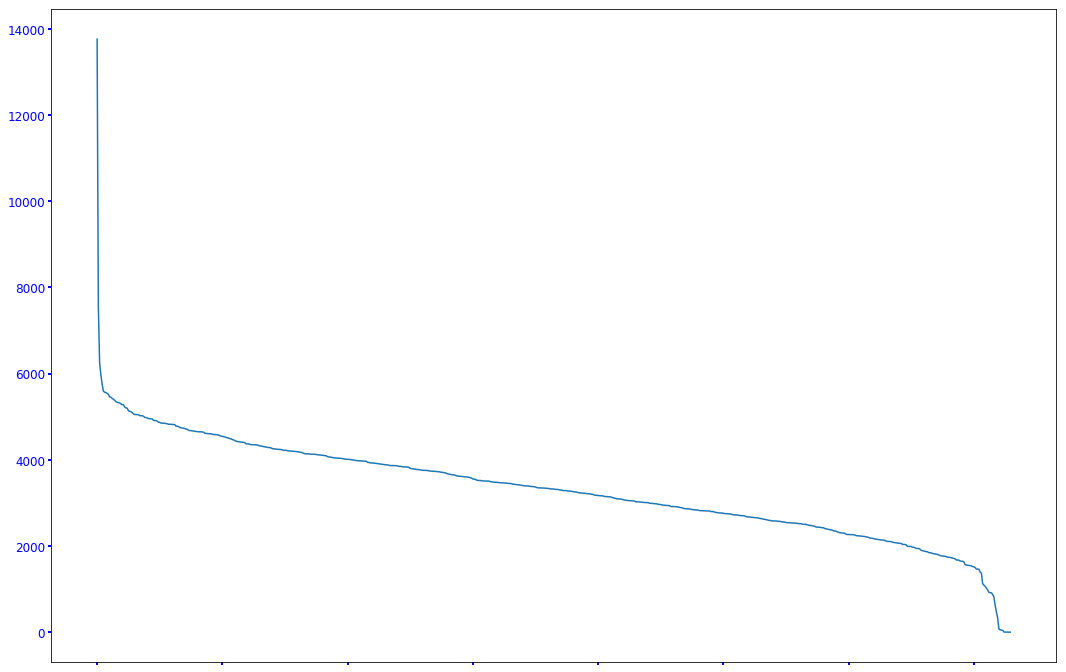

In [102]:
figure, ax = plt.subplots(figsize=(18, 12))
ax.tick_params(direction='out', length=3, width=2, colors='b', grid_color='r', grid_alpha=0.5, labelsize='large')
df_lemmas['_drawer'].value_counts().plot()

Fixing ambiguous information for two typists with same abbreviation:

- Christine Schellhorn (up to drawer 403 – this was her last drawer 
- Sonja Schwaiger (from drawer 636 – this was her first drawer)

In [103]:
df_lemmas[df_lemmas['_typist'] == 'Christine Schellhorn']['_drawer'].unique()

array(['HK 157', 'HK 000', 'HK 165', 'HK 170', 'HK 176', 'HK 188',
       'HK 240', 'HK 225', 'HK 234', 'HK 243', 'HK 255', 'HK 263',
       'HK 270', 'HK 276', 'HK 281', 'HK 290', 'HK 296', 'HK 301',
       'HK 311', 'HK 318', 'HK 324', 'HK 332', 'HK 334', 'HK 339',
       'HK 347', 'HK 353', 'HK 361', 'HK 376', 'HK 383', 'HK 389',
       'HK 403', 'HK 636', 'HK 652', 'HK 665', 'HK 673', 'HK 687',
       'HK 703', 'HK 708', 'HK 724', 'HK 729', 'HK 735', 'HK 739',
       'HK 749', 'HK 755', 'HK 765', 'HK 771', 'HK 780', 'HK 789',
       'HK 795', 'HK 804', 'HK 812', 'HK 821', 'HK 831', 'HK 836',
       'HK 844', 'HK 854', 'HK 856', 'HK 858', 'HK 867', 'HK 870',
       'HK 881'], dtype=object)

In [104]:
drw = df_lemmas[df_lemmas['_typist'] == 'Christine Schellhorn'].index

func = lambda x:int(x[3:])
for idx in drw:
    x = df_lemmas.loc[idx,'_drawer']
    if func(x) > 500:
        df_lemmas.loc[idx]['_typist'] = 'Sonja Schwaiger'

In [105]:
df_lemmas['_typist'].sort_values().value_counts()

Barbara Piringer          375962
Claudia Hareter-Kroiss    253213
Monika Platzer            211855
Bettina Barabas           186280
Lana Mayer                150502
Renate Eckel              132557
Birgit Hofstetter         117544
Sonja Schwaiger           115656
Eva Pudill                102226
Christian Nedoma           93332
Monika Ranftl              92024
Christine Schellhorn       78757
Bettina Fürst              77013
Angelika Eisenhut          72959
Berthold Föger             69227
Markus Pascher             52137
Sybille Groh               48845
Karin Kupitz               45738
Barbara Konate             34644
Marianne Pühringer         31013
Christine Hager            24985
Tamara Loitfellner         17048
Veronika Gasser            12159
Manfred Lagler             10409
Johanna Grützbauch          7464
Reinhard Bachmaier          2823
Name: _typist, dtype: int64

In [106]:
df_lemmas[['_typist',
           'hauptlemma_normalized',
           'hauptlemma_orig',
           'hauptlemma_unique',
           'nebenlemma_normalized',
           'nebenlemma_orig',
           'nebenlemma_unique',]].groupby(['_typist']).count()

,hauptlemma_normalized,hauptlemma_orig,hauptlemma_unique,nebenlemma_normalized,nebenlemma_orig,nebenlemma_unique
_typist,,,,,,
Angelika Eisenhut,38782,38782,29119,2105,2106,806
Barbara Konate,19996,19997,13225,1386,1386,705
Barbara Piringer,217140,217500,155106,22702,22708,18446
Berthold Föger,39013,39013,26843,1688,1688,1370
Bettina Barabas,101220,101222,61244,2526,2531,1327
Bettina Fürst,44793,44793,25618,5265,5265,1835
Birgit Hofstetter,63571,63571,46441,9895,9895,5501
Christian Nedoma,51119,51120,39292,5376,5376,3522
Christine Hager,15853,15853,6907,1378,1383,683


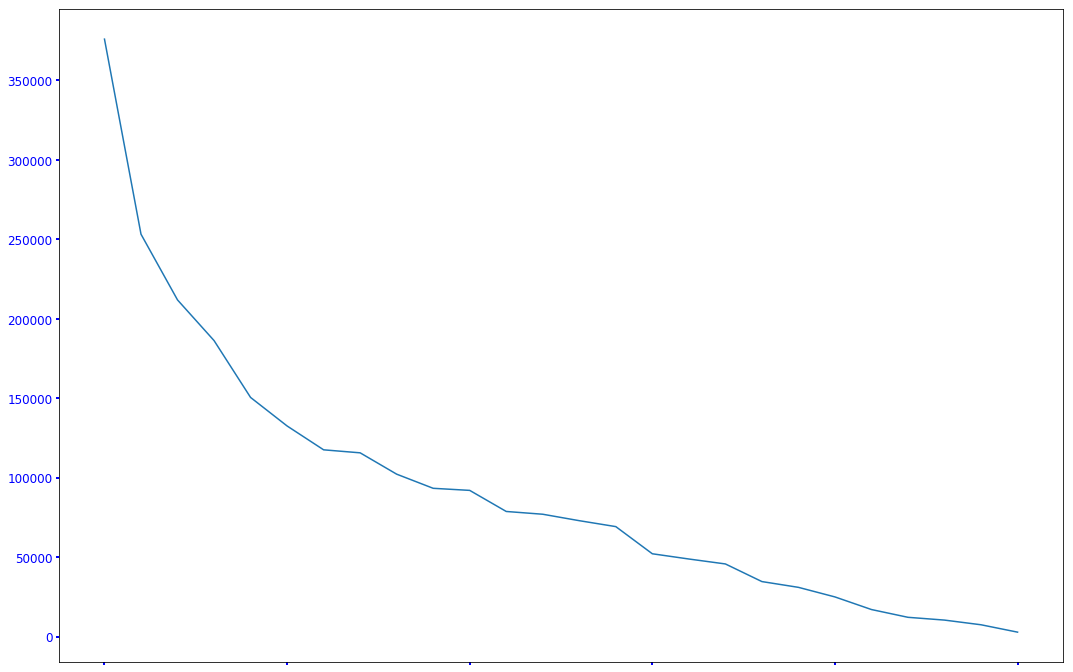

In [107]:
figure, ax = plt.subplots(figsize=(18, 12))
ax.tick_params(direction='out', length=3, width=2, colors='b', grid_color='r', grid_alpha=0.5, labelsize='large')
df_lemmas['_typist'].value_counts().plot()

#### 4) number of headwords per letter

In [108]:
headwords_idx = set(list(df_lemmas.hauptlemma_unique.dropna().index) \
                + list(df_lemmas.hauptlemma_normalized.dropna().index) \
                + list(df_lemmas.hauptlemma_orig.dropna().index) \
                + list(df_lemmas.nebenlemma_unique.dropna().index) \
                + list(df_lemmas.nebenlemma_normalized.dropna().index) \
                + list(df_lemmas.nebenlemma_orig.dropna().index))

In [109]:
headwords_list = []

for idx in headwords_idx:
    if df_lemmas.hauptlemma_unique.iloc[idx]:
        headwords_list.append(df_lemmas.hauptlemma_unique.iloc[idx])
    elif df_lemmas.hauptlemma_normalized.iloc[idx]:
        headwords_list.append(df_lemmas.hauptlemma_normalized.iloc[idx])
    elif df_lemmas.hauptlemma_orig.iloc[idx]:
        headwords_list.append(df_lemmas.hauptlemma_orig.iloc[idx])
    elif df_lemmas.nebenlemma_unique.iloc[idx]:
        headwords_list.append(df_lemmas.nebenlemma_unique.iloc[idx])
    elif df_lemmas.nebenlemma_normalized.iloc[idx]:
        headwords_list.append(df_lemmas.nebenlemma_normalized.iloc[idx])
    elif df_lemmas.nebenlemma_orig.iloc[idx]:
        headwords_list.append(df_lemmas.nebenlemma_orig.iloc[idx])
        
first_letter = [x[0].upper() for x in headwords_list]

In [110]:
freq_letters = nltk.FreqDist(first_letter)

freq_letters.pop('(')
freq_letters.pop(' ')
freq_letters.pop('←')
freq_letters.pop('[')
freq_letters.pop(':')
freq_letters.pop('^')
freq_letters.pop('?')
freq_letters.pop('1')
freq_letters.pop('2')
freq_letters.pop('6')
freq_letters.pop('─')
freq_letters.pop('†')
freq_letters.pop('~')
freq_letters.pop('|')
freq_letters.pop('\xa0')

freq_letters.most_common(50)

[('S', 373210),
 ('G', 192629),
 ('F', 190978),
 ('H', 189854),
 ('K', 180359),
 ('A', 162978),
 ('W', 122670),
 ('M', 107322),
 ('R', 104967),
 ('L', 101267),
 ('P', 90019),
 ('Z', 85329),
 ('T', 74090),
 ('E', 71092),
 ('D', 61183),
 ('N', 54603),
 ('U', 33973),
 ('J', 21494),
 ('O', 21345),
 ('B', 13719),
 ('Ü', 11380),
 ('I', 9663),
 ('Ë', 7563),
 ('Ê', 5051),
 ('Ô', 3280),
 ('Q', 2768),
 ('Ö', 2668),
 ('Â', 1275),
 ('Ä', 1132),
 ('V', 324),
 ('C', 98),
 ('Û', 82),
 ('X', 62),
 ('Y', 34),
 ('Á', 14),
 ('Å', 9),
 ('Ú', 3),
 ('!', 3),
 ('SS', 3),
 ('Ó', 2),
 ('9', 2),
 ('É', 1),
 ('Î', 1),
 ('+', 1),
 ('Ǎ', 1),
 ('Ē', 1),
 ('5', 1),
 ('*', 1),
 ('¹', 1),
 ('Í', 1)]

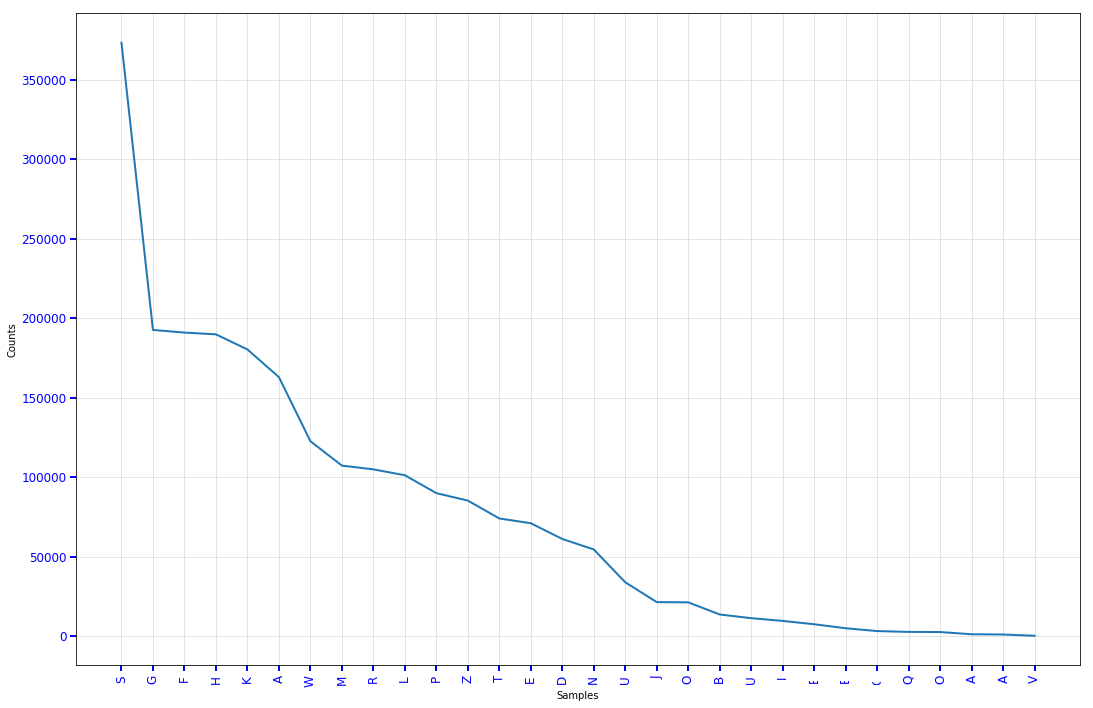

In [111]:
figure, ax = plt.subplots(figsize=(18, 12))
ax.tick_params(direction='out', length=6, width=2, colors='b', grid_color='r', grid_alpha=0.5, labelsize='large')
freq_letters.plot(30,cumulative=False,)

#### 5) number of headwords per location

In [112]:
print(len(set(df_lemmas.Bundesland.dropna().index)))
print(len(set(df_lemmas.Ort.dropna().index)))
print(len(set(df_lemmas.Bundesland.dropna().index).intersection(set(df_lemmas.Ort.dropna().index))))

1316889
1198447
1198447


In [113]:
# there is no intersection between records with simple placenames and records with original placenames
set(df_lemmas.simple_placeName.dropna().index).intersection(set(df_lemmas.orig_placeName.dropna().index))

set()

In [114]:
# and there is no intersection between records with simple placenames and records with Ort information
set(df_lemmas.simple_placeName.dropna().index).intersection(set(df_lemmas.Ort.dropna().index))

set()

In [115]:
locations_idx = set(df_lemmas.simple_placeName.dropna().index)\
.union(set(df_lemmas.Ort.dropna().index))\
.union(df_lemmas.orig_placeName.dropna().index)

In [116]:
locations_list = []

for idx in locations_idx:
    if df_lemmas.simple_placeName.iloc[idx]:
        locations_list.append(df_lemmas.simple_placeName.iloc[idx])
    elif df_lemmas.Ort.iloc[idx]:
        locations_list.append(df_lemmas.Ort.iloc[idx])
    elif df_lemmas.orig_placeName.iloc[idx]:
        locations_list.append(df_lemmas.orig_placeName.iloc[idx])

In [117]:
freq_locations = nltk.FreqDist(locations_list)
freq_locations.most_common(50)

[('Wien', 71263),
 ('Mühlheim am Inn', 34694),
 ('(Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW', 33278),
 ('Gmunden', 33056),
 ('Kautzen', 32858),
 ('Kufstein', 21403),
 ('Linz', 21282),
 ('Plattetschl. BöW', 20835),
 ('Thiersee $Tiersee$', 20598),
 ('Poysdorf', 19641),
 ('Rangersdorf', 16430),
 ('Stainz', 16174),
 ('(Umg./Bz.) Braunau OÖ', 15722),
 ('Traun', 15627),
 ('Dunkelsteinerwald', 15541),
 ('Hohenfurth SBö.', 15374),
 ('Königswerth Egerld.', 14392),
 ('Fusch an der Großglocknerstraße', 13364),
 ('Puchberg am Schneeberg', 12969),
 ('Obermösel in Gm. Mösel Gott.(Slow.)', 12555),
 ('Pottendorf', 12501),
 ('Fendels', 11318),
 ('Kleinlobming', 11088),
 ('Sonnbg. SBö.', 10836),
 ('Straßburg', 10781),
 ('Ulrichsberg', 10609),
 ('Tullnitz SMä.', 10286),
 ('Rohr im Gebirge', 10276),
 ('Herzogenburg', 10084),
 ('Imst', 9854),
 ('Pilgersdorf', 9769),
 ('Gr.Tajax SMä.', 9579),
 ('Kumrowitz Brünn (Tschech.)', 9416),
 ('St. Gilgen', 9103),
 ('Hollabrunn', 8843),
 ('Gr.Arlt. in Sa.', 8769),

#### 6) average number of entries per headword

In [118]:
freq_words = nltk.FreqDist(headwords_list)
freq_words.most_common(50)

[('gên', 9039),
 ('kemmen', 5883),
 ('Hand', 5088),
 ('Haut', 4253),
 ('Kopf', 3931),
 ('Leib', 3790),
 ('Zand', 3671),
 ('sein', 3283),
 ('sehen', 3267),
 ('lich', 3200),
 ('tuon', 3131),
 ('rôt', 2773),
 ('klein', 2636),
 ('halten', 2617),
 ('Hâr', 2573),
 ('Nase', 2375),
 ('schwarz', 2308),
 ('ziehen', 2261),
 ('Hôhzeit', 2230),
 ('haben', 2208),
 ('schlagen', 2190),
 ('faren', 2171),
 ('machen', 2023),
 ('können', 2012),
 ('Mann', 1987),
 ('ein', 1975),
 ('lâßen', 1960),
 ('Maul', 1952),
 ('schwellen', 1945),
 ('guot', 1941),
 ('gëben', 1924),
 ('Georg', 1902),
 ('schön', 1878),
 ('Ort', 1859),
 ('Stein', 1847),
 ('schneiden', 1825),
 ('Fleisch', 1796),
 ('kurz', 1749),
 ('ër', 1736),
 ('Kind', 1732),
 ('helfen', 1687),
 ('Haus', 1685),
 ('schwär', 1683),
 ('Finger', 1672),
 ('ê', 1652),
 ('lang', 1628),
 ('schauen', 1613),
 ('grôß', 1608),
 ('Schneider', 1597),
 ('weiß', 1581)]

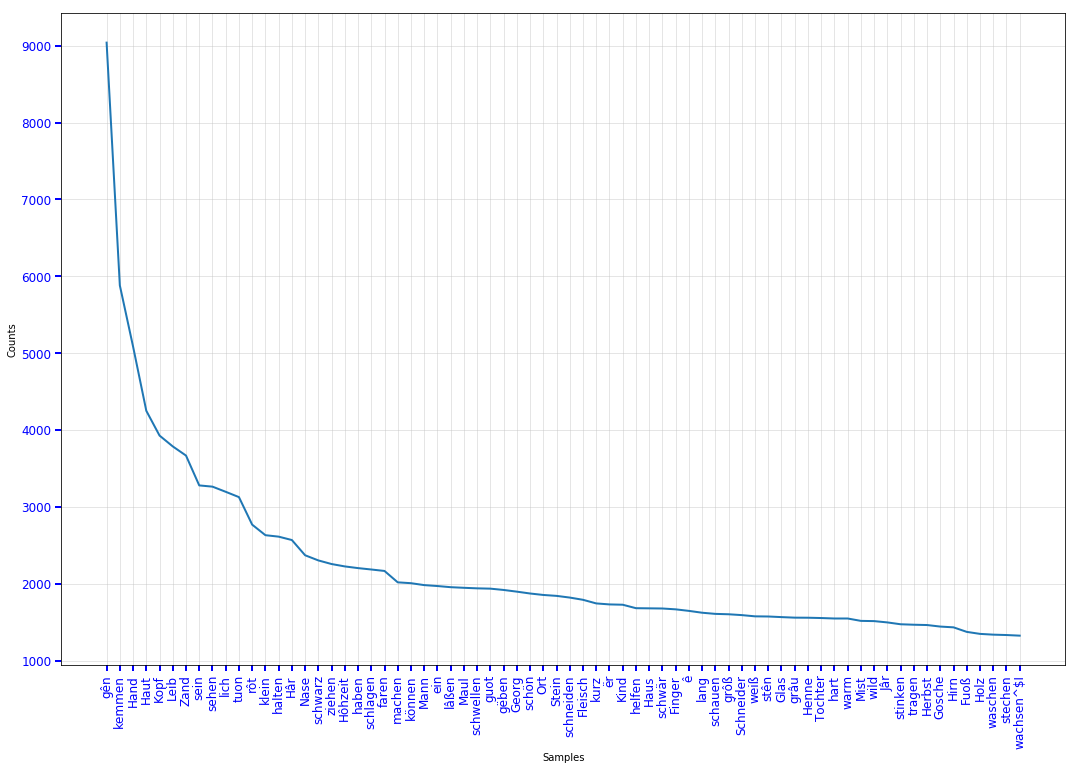

In [119]:
figure, ax = plt.subplots(figsize=(18, 12))
ax.tick_params(direction='out', 
               length=6, 
               width=2, 
               colors='b', 
               grid_color='r', 
               #labelrotation=45,
               grid_alpha=0.5, 
               labelsize='large')

freq_words.plot(70,cumulative=False,)

In [120]:
len(headwords_list)/len(freq_words)

9.61762763716607

#### 7) number of different definitions / meanings

#### 8) number of locations cited

In [121]:
len(freq_locations)

27542

In [122]:
for col in regions_info:
    print(col, '--->', len(df_lemmas[col].unique()))

Bundesland ---> 10
Bundesland_idno ---> 10
Gemeinde ---> 1147
Großregion ---> 33
Großregion_idno ---> 32
Kleinregion ---> 324
Kleinregion_idno ---> 322
Ort ---> 1146
Ort_idno ---> 1147
simple_placeName ---> 25494
orig_placeName ---> 4437
placeName_id ---> 1308
usg_corresp ---> 21


In [123]:
#fine grained locations --> Ort + simple placename + original placename
len(set(df_lemmas.Ort).union(set(df_lemmas.simple_placeName)).union(df_lemmas.orig_placeName))

30231

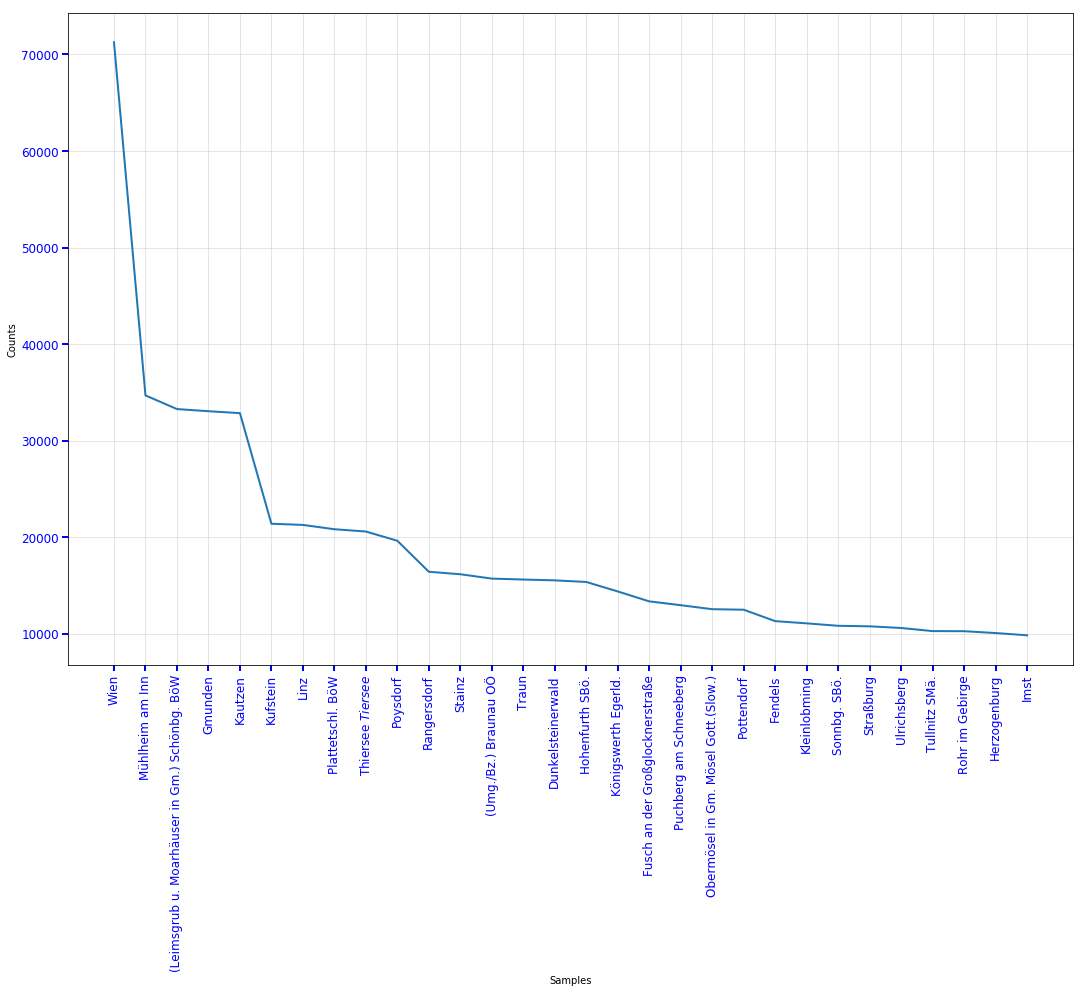

In [124]:
figure, ax = plt.subplots(figsize=(18, 12))
ax.tick_params(direction='out', 
               length=6, 
               width=2, 
               colors='b', 
               grid_color='r', 
               #labelrotation=45,
               grid_alpha=0.5, 
               labelsize='large')

freq_locations.plot(30,cumulative=False,)

#### 9) number of sources cited

#### 10) number of different people cited

#### 11) number of headwords per person

#### 12) number of entries per person

#### 13) number of concepts per questionnaire

#### 14) number of headwords related to questionnaire

In [125]:
df_lemmas.fragebogenNummer.value_counts()

23I6b: Haut m. Adj., Syn. (behaart/Pelz, gelbl.,*); Zshg. Hautfarbe-Haarfarbe/Charakter?                       2707
1A20: Kopf/Schädel als Gw. (Weiberkopf)                                                                        2382
1A3: Kopf/Haupt (übertr.) in Vergl./Ra.                                                                        2286
21C8: Fleisch best.Lebewesen (Heiden-*, Hirsch-,*)                                                             2262
1E12: Backenstreich/Ohrfeige; leicht/stark/schallend                                                           2047
20B2: Blut m. Vb. (es rinnt/hämmert; B. verlieren,*)                                                           2013
43A54b: kommen m. Ziel-/Ortsang. (aus d.Sinn k.,*)                                                             1982
1H1: Mund/Maul; Füg./Ra.                                                                                       1956
42A13d: gehn m. Ziel-/Ortsang. (fortg.; aufs Land g.;*)                 

In [32]:
condition = df_lemmas['fragebogenNummer'].dropna().str.contains("EFb")
idx1 = set(df_lemmas['fragebogenNummer'].dropna()[condition].index)
len(df_lemmas['fragebogenNummer'][idx1])

156043

In [34]:
condition = df_lemmas['fragebogenNummer'].dropna().str.contains("MüWi")
idx2 = set(df_lemmas['fragebogenNummer'].dropna()[condition].index)
len(df_lemmas['fragebogenNummer'][idx2])

755

In [38]:
idx3 = set(df_lemmas['fragebogenNummer'].dropna().index)
idx3 = idx3 - idx1
idx3 = idx3 - idx2
len(df_lemmas['fragebogenNummer'][idx3])

1140338

In [39]:
df_lemmas['_fragebogen'] = None
df_lemmas.loc[idx1,'_fragebogen'] = 'Additional'
df_lemmas.loc[idx2,'_fragebogen'] = 'Geographic'
df_lemmas.loc[idx3,'_fragebogen'] = 'Systematic'

In [43]:
df_lemmas['_fragebogen'].value_counts(dropna=False)

Systematic    1140338
NaN           1119363
Additional     156043
Geographic        755
Name: _fragebogen, dtype: int64

In [40]:
print('Systematic: ', df_lemmas[df_lemmas['_fragebogen'] == 'Systematic']['_bestlemma'].value_counts().count())
print('Additional: ', df_lemmas[df_lemmas['_fragebogen'] == 'Additional']['_bestlemma'].value_counts().count())
print('Geographic: ', df_lemmas[df_lemmas['_fragebogen'] == 'Geographic']['_bestlemma'].value_counts().count())

Systematic:  118269
Additional:  7849
Geographic:  447


#### 15) number of headwords related to questions

#### 16) number of entries related to questions related to authors of questions/questionnaires

#### 17) number of headwords related to questions related to authors of questions/questionnaires

#### 18) number of locations per person (that is identified)

#### 19) number of female:male collectors

#### 20) average number of entries per questions

#### 21) number of entries related to questionnaires

In [136]:
df_lemmas['_fragebogen'].value_counts()

Systematic    1140338
Additional     156043
Geographic        755
Name: _fragebogen, dtype: int64

#### 22) number of entries related to historical sources

#### 23) number of entries related to historical poetic sources

#### 24) number of entries related to "free collections"

#### 25) number of people working on the collection since the start

#### 26) names of people working on the collection since the start

#### 27) number of collectors per questionnaire

#### 28) average number of definitions per entry / paper slip

#### 29) average number of entries per person

#### 30) average number of headwords per person

#### 31) average number of entries per type of location

#### 32) average number of headwords per type of location

#### 34) persons sorted by the number of headwords (and a list of those headwords) that are least frequent in the corpus

#### 35) headwords sorted by frequency

#### 36) headwords sorted by frequency related to certain types of regions (e.g AT., bundesland, smallest regional unit, municipality)

#### 37) number of entries with time information

In [137]:
for year in df_lemmas.date.unique():
    print(year)

None
16.Jh.
1730
1363
1405
15.u.16.Jh.
17.Jh.
1549
Anf.15.Jh.
1399
Mitte 15.Jh.
vor 1483
1266
1431
1387
1392
1401
1495
15./16.Jh.
Mitte 16.Jh.
1705
1585
1513
O 1387
1759
1734
O 1642
1778
1623
1560-1594
2.Hä.16.Jh.
um 1600
1500
1607
1588
1587
1754
1597
1667
1507
1574
15.Jh.
1572
1745
1578
1380
O 1394
1512
15.6. 1575
1621
1467
1590
1492
1434
1732
1493-1523
1699
1648-1658
1.Hä.18.Jh.
1342
1297
1441
1515
1550
1772
O 1563
Mitte d.15.Jh.
1679
18.Jh.
1581
1376
1629
1630
C kais.Komm. 1607
1623; 1699
16.-18.Jh.
1608; 1651 [?]
1682
1715
4.2.1308
a. 1494
1701
1418-1454
a. 1580
1345
1290
1460
16. jh.
1465
a. 1426
1354
1509
1532
1463
1477
18. jh.
14.6.1621
1258
17. jh.
1564
a. 1431
19. 4. 1575
1284
1291
1375
1372
1323
1563
[24.3.] 1568
1188-93, C 13. Jh.
1521
1648
a. 1582
15. jh.
a. 1613
a. 1520
a. 1484
1668
1573
a. 1528
Mitte 16. Jh.
17.jh.
16.jh.
1436
14. Jh.
1427
vor 1621
a. 1565
1583
a. 1726
1. H. 16. Jh.
1. Hä. 16. Jh.
Jänner 1951
1494
vor 1511?
6.8.1592
1523
1581-95
1555-90
20.6.1567
1337
177

(vor 1127)
O 1680
O o.J., ca. 1592
15.12.1546
C 1482O 1466
o.J.
9.9.28
4.9.1928
1379,1427
1257
1490 (1419?)
17.1.1842
Übers.1470
Konz 1477
15541549
Konz.1478; O 1507, O 1533
16.u.17.Jh.
12.2.25
schon 1520
Aug.1913
1083
1058
1226
1171
1195
1209
1246
1268
23. 8. 1639
1703
27.7.1415
18. Jhd. (1768)
(vor 11.4.) 1597
30.11. 1299
1838
[90 jährige Frau]
1729
1906; 1665
August 1951
2.10.1982
ca. 1530
Anf. 16. Jh.
1908
2.8.1449
25. Juli 1240
Orig. aus 1306
23.5.1366
14.4.1288
Vidim. 1384
1848
1931
1658,1715
1659
28.2.94
1904
20.3.1921
27.6.1361
22.8.1982
6.12.27
15.7.1562
5.7.1311
1978
18.6.1518
17. Jh
ab 1774
seit ca. 1920
nach 1918
1900
2.Hä.18.Jh.
19351935
17.u.18.Jh.
1711-1719
1962
1891
O.1642
seit 14.Jh.
6.Aug.1921
28.10.1928
28.2.1959
25.11.1981
2.5.1981
16. 9. 1926
15.Jh.?
1695-1780
1914
12.Febr.1928
5.XI.31
Aug.1951
seit 1369
Anf 15.Jh.
14371439
1658 u.a.
1580-95
1587-95
6. 8. 1592
1591-1595
1689 u.a.J.
1582-1585
1578 29/ 3
24.8.1414
10.1.1573
1898
17.1.1745
26.2.1327
1633
12.8.1640
188

8. 3. 1925
9. 8. 1928
1554-88
31. 1. 1933
16. 2. 1925
O. 1507
März 1952
28. 2. 1929
4. 10. (1929)
Oktober 1952
C 1500>1420
ca. 1526
14. 5. 1612
O1400
1560-1580
16./17. Jh.
anno '19
ca. 1960
1169; 1171/72
ca 1300
19.Jg
L.O. v. 1553; v. 1616
(1399)
a. 1399
anno1487
1950/60
O. 1472
O. 1158
O. 147z
O. 29. 10. 1595
O. ca. 1490
C. 1534
B 1560-94
O. 1533
O. 1675
21. 8. 1366
15. 8. 1340
1. 5. 1310
12. 11. 1926
12. 12. 1925
16.3.1571
1852
1. 12. '26
1591-93
aus Timelkam (Hausruck)
Mitte d. 15. Jhrh.
ad 1455
17. 1. 1864
vor 2. Weltkrieg
7. 11. 1572
1684-17091582
2. 6. 1575
1556 3/7
23.5.1925
2. 12. 1926
1. 12. 1926
Wallern
17. 1. 1485
9. 6. 1924
O. 1653
ad 1513
34,12
Oca. 1371
seit 1634
2. Hälfte 16 Jh.
1239
O 1361
1306-1346
16.,17.Jhdt.
a.1443
a.1580
a.1670
a.1758
a.1565
1. Hälfte des 18.Jhdts
a.1532
a.1418
a.1648-1658
Ende 15.Jhdt.
a.1495
a. 1564
(1642)
(1521)
(1465)
a. 1570
1. Hälfte 18.Jhdt.
a.1666
a. 1606
v. 1350
18. 7. 1582
16. / 17. Jh.
Steyr 2. Hälfte 16. Jh.
c. 1607
O. 1595
vor 70 Jahre

In [138]:
df_lemmas.date.value_counts()

17.Jh.                     738
16.Jh.                     707
1587                       634
1623                       631
15.Jh.                     567
16. Jh.                    498
17. Jh.                    486
1550                       486
1581                       462
1532                       455
1969                       431
1463                       400
1368                       388
15. Jh.                    377
1498                       345
1465                       329
1553                       319
1367                       311
1590                       304
1454                       304
1573                       302
1467                       292
1494                       291
1365                       287
1460                       274
1621                       262
1624                       260
1370                       257
1514                       256
1699                       254
                          ... 
bald nach 1600               1
15./16. 

Substituting references to centuries with the middle of the century (e.g. 16.Jh. ---> 1650)

In [139]:
df_lemmas['_year'] = df_lemmas['date'].str.extract('([0-9]{4})', expand=True)
df_lemmas['_year'].sort_values().value_counts()

1587    653
1623    641
1550    533
1581    480
1532    473
1648    443
1969    434
1463    409
1368    394
1590    374
1465    371
1460    366
1553    365
1498    349
1621    335
1454    318
1367    315
1418    314
1573    312
1467    306
1494    302
1365    289
1400    287
1624    279
1560    272
1361    265
1370    260
1514    258
1513    258
1699    257
       ... 
1998      1
1158      1
1012      1
1017      1
1185      1
1184      1
1198      1
1103      1
1078      1
1113      1
1059      1
1088      1
1261      1
1174      1
1216      1
1205      1
1231      1
1999      1
1230      1
0132      1
1106      1
1069      1
1196      1
1282      1
1149      1
2008      1
1080      1
1273      1
1267      1
1138      1
Name: _year, Length: 865, dtype: int64

In [140]:
df_lemmas['_year'] = df_lemmas['date'].str.extract('(1[0-9]{1}[\s.]+[JjHh.]{2,})', expand=True)
df_lemmas['_year'].sort_values().value_counts()

16.Jh.     1051
16. Jh.     794
17.Jh.      783
15.Jh.      645
17. Jh.     521
15. Jh.     422
18.Jh.      266
17.jh.      239
16. jh.     224
16.jh.      210
17. jh.     202
18. Jh.     199
15. jh.     169
15.jh.      153
14.Jh.      105
14. Jh.     102
16.Jh        78
18.jh.       62
16. Jh       58
15.Jh        56
18. jh.      49
17.Jh        48
15. Jh       44
17. Jh       39
14. Jh       31
18.Jh        25
14.Jh        25
18. Jh       24
16 Jh.       18
16 Jh        16
           ... 
18.jh         2
12. Jh.       2
17 Jh         2
17.jh         2
17.JH.        2
18 Jh.        2
13.Jh         2
19.Jh         2
15. jh        2
11.Jh.        2
15.jh         2
14 Jh.        2
16.jh         1
13.jh.        1
12.Jh         1
10 Jh.        1
12 Jh         1
16. JH.       1
14. Hh        1
13. Jh        1
18 JH         1
19.jh.        1
15 .Jh.       1
11. Jh.       1
18 Jh         1
16 jh.        1
14. jh        1
10.Jh.        1
18. jh        1
18 jh         1
Name: _year, Length: 78,

In [142]:
df_lemmas[df_lemmas['_year'].isna()]['date'].value_counts()

1587                                                                                                                                       634
1623                                                                                                                                       631
1550                                                                                                                                       486
1581                                                                                                                                       462
1532                                                                                                                                       455
1969                                                                                                                                       431
1463                                                                                                                                       400

In [143]:
df_lemmas['date'].str.extract('(1[0-9]{1}[\s.]+[JjHh.]{2,})', expand=True)[0].unique()

array([nan, '16.Jh.', '17.Jh.', '15.Jh.', '18.Jh.', '16. jh.', '18. jh.',
       '17. jh.', '13. Jh.', '15. jh.', '16. Jh.', '17.jh.', '16.jh.',
       '14. Jh.', '14.Jh', '13.Jh.', '15.jh.', '15. Jh.', '14.Jh.',
       '15. Jh', '17. Jh.', '18. Jh', '14. jh.', '18. Jh.', '15.Jh',
       '18.Jh', '16.Jh', '17 jh.', '18.jh.', '17.Jh', '14.jh.', '18 jh.',
       '16. Jh', '19.Jh.', '12.Jh.', '19.jh.', '17 Jh.', '14. Jh',
       '16 Jh', '17. Jh', '15 Jh', '17.JH.', '16 Jh.', '11.Jh.', '18 Jh.',
       '18 JH', '18 Jh', '19. Jh.', '15 Jh.', '16. JH.', '14. Hh',
       '17.jh', '15. jh', '19.Jh', '18.jh', '12 Jh', '15 jh.', '13.Jh',
       '10 Jh.', '12. Jh.', '10. Jh.', '19. Jh', '16 jh.', '13.jh.',
       '15.jh', '12.Jh', '10.Jh.', '15 jh', '16. jh', '17 jh', '14. jh',
       '18 jh', '17 Jh', '14 Jh.', '18. jh', '13. Jh', '15 .Jh.', '16.jh',
       '11. Jh.'], dtype=object)

#### 38) average number of entries per collection

#### 39) percentage of headwords in a certain location per person

#### 40) percentage of plant names per letter  

In [144]:
len(df_lemmas) - len(locations_idx)

686299

#### Exporting the Enriched Dataframe

In [14]:
df_lemmas.to_pickle('./df_lemmas.pkl')

#### Building a SQLite Database

In [25]:
conn = sqlite3.connect('./lemmas_db.sqlite')

In [16]:
df_lemmas.applymap(str).head()

,Bundesland,Bundesland_idno,Gemeinde,Großregion,Großregion_idno,Kleinregion,Kleinregion_idno,Ort,Ort_idno,archiv,...,tustep,usg_corresp,verweise,_coordinates,_location,_typist,_drawer,_fragebogen,_bestlemma,_year
0,None,None,None,None,None,None,None,None,None,"HK 154, d154^#1.1 = d1540308.pir^#1.1",...,"('diaun',)",None,None,None,None,Barbara Piringer,HK 154,None,Diaun,nan
1,None,None,None,None,None,None,None,None,None,"HK 154, d154^#2.1 = d1540308.pir^#2.1",...,"('diaun',)",None,None,None,None,Barbara Piringer,HK 154,None,Diaun,nan
2,None,None,None,None,None,None,None,None,None,"HK 154, d154^#3.1 = d1540308.pir^#3.1",...,"('diaun',)",None,None,None,None,Barbara Piringer,HK 154,None,Diaun,nan
3,None,None,None,None,None,None,None,None,None,"HK 154, d154^#4.1 = d1540308.pir^#4.1",...,"('tib',)",None,None,None,None,Barbara Piringer,HK 154,Systematic,tib,nan
4,None,None,None,None,None,None,None,None,None,"HK 154, d154^#5.1 = d1540308.pir^#5.1",...,"('tib',)",None,None,None,None,Barbara Piringer,HK 154,Systematic,tib,nan


In [17]:
df_lemmas.applymap(str).to_sql(name='lemmas', con=conn)

In [26]:
cur = conn.cursor()

In [19]:
cur.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cur.fetchall())

[('lemmas',)]


In [22]:
q = '''
select _typist, _drawer, _fragebogen, _bestlemma  from lemmas limit 40;
'''

In [27]:
cur.execute(q)
for entry in cur.fetchall():
    print(entry)

('Barbara Piringer', 'HK 154', 'None', 'Diaun')
('Barbara Piringer', 'HK 154', 'None', 'Diaun')
('Barbara Piringer', 'HK 154', 'None', 'Diaun')
('Barbara Piringer', 'HK 154', 'Systematic', 'tib')
('Barbara Piringer', 'HK 154', 'Systematic', 'tib')
('Barbara Piringer', 'HK 154', 'Systematic', 'tib')
('Barbara Piringer', 'HK 154', 'Systematic', 'tib')
('Barbara Piringer', 'HK 154', 'None', 'Diebede')
('Barbara Piringer', 'HK 154', 'None', 'Diebede')
('Barbara Piringer', 'HK 154', 'None', 'Diebede')


In [24]:
conn.close()